target: ETHUSDT

In [31]:
# import package
import finlab_crypto
import numpy as np
import pandas as pd
import math

# data feeds
import datetime
import backtrader as bt
import backtrader.feeds as btfeeds

In [32]:
# get target crypto price
def getting_crypto_price(crypto, timestamp):
    #
    price_data = finlab_crypto.crawler.get_all_binance(crypto, timestamp)
    
    return price_data

In [49]:
# get BTC history price
BTC_hist_price = getting_crypto_price('ETHUSDT', '1d')

All caught up..!


In [50]:
data = bt.feeds.PandasData(dataname=BTC_hist_price)

In [51]:
# define custom indicator
class DonchianChannels(bt.Indicator):
    # The alias of this object, so we can use DCH/DonchianChannel to call this indicator later
    alias = ('DCH', 'DonchianChannel',)
    
    lines = ('dcm', 'dch', 'dcl',)  # dc middle, dc high, dc low
    
    # Calculation method of DonchianChannels: use the data of the past 20 days to calculate, so the period is 20, 
    # lookback means whether to include today's data in the calculation, lookback is set to -1

    params = dict(
        period=20,
        lookback=-1,  # consider current bar or not
    )
    
    # (True)draw another picture of Indicators, (False) in same picture 
    plotinfo = dict(subplot=False)  # plot along with data
    
    # Drawing settings, ls is line style, '--' stands for dotted line
    plotlines = dict(
        dcm=dict(ls='--'),  # dashed line
        dch=dict(_samecolor=True),  # use same color as prev line (dcm)
        dcl=dict(_samecolor=True),  # use same color as prev line (dch)
    )
    
    def __init__(self):
        # hi and lo refer to the highest and lowest price of the daily stock price
        hi, lo = self.data.high, self.data.low
        
        # Depending on the needs, decide whether to read the data from the previous day. 
        # It has been defined above that lookback exists ,
        # so here it will run directly from the data from the previous day.
        if self.p.lookback:  # move backwards as needed
            hi, lo = hi(self.p.lookback), lo(self.p.lookback)
        
        # Define how the three lines are calculated
        self.l.dch = bt.ind.Highest(hi, period=self.p.period)
        self.l.dcl = bt.ind.Lowest(lo, period=self.p.period)
        self.l.dcm = (self.l.dch + self.l.dcl) / 2.0  # avg of the above

In [56]:
# Strategy
class DonchianChannels_Strategy(bt.Strategy):
    def __init__(self):
        # DonchianChannels indictor
        self.myind = DCH()

    def next(self):
        if self.data[0] > self.myind.dch[0]:
            self.buy()
        elif self.data[0] < self.myind.dcl[0]:
            self.sell()


In [57]:
class CashMarket(bt.analyzers.Analyzer):
    """
    Analyzer returning cash and market values
    """

    def create_analysis(self):
        self.rets = {}
        self.vals = 0.0

    def notify_cashvalue(self, cash, value):
        self.vals = (
            self.strategy.datetime.datetime().strftime("%Y-%m-%d"),
            cash,
            value,
        )
        self.rets[len(self)] = self.vals

    def get_analysis(self):
        return self.rets

<IPython.core.display.Javascript object>


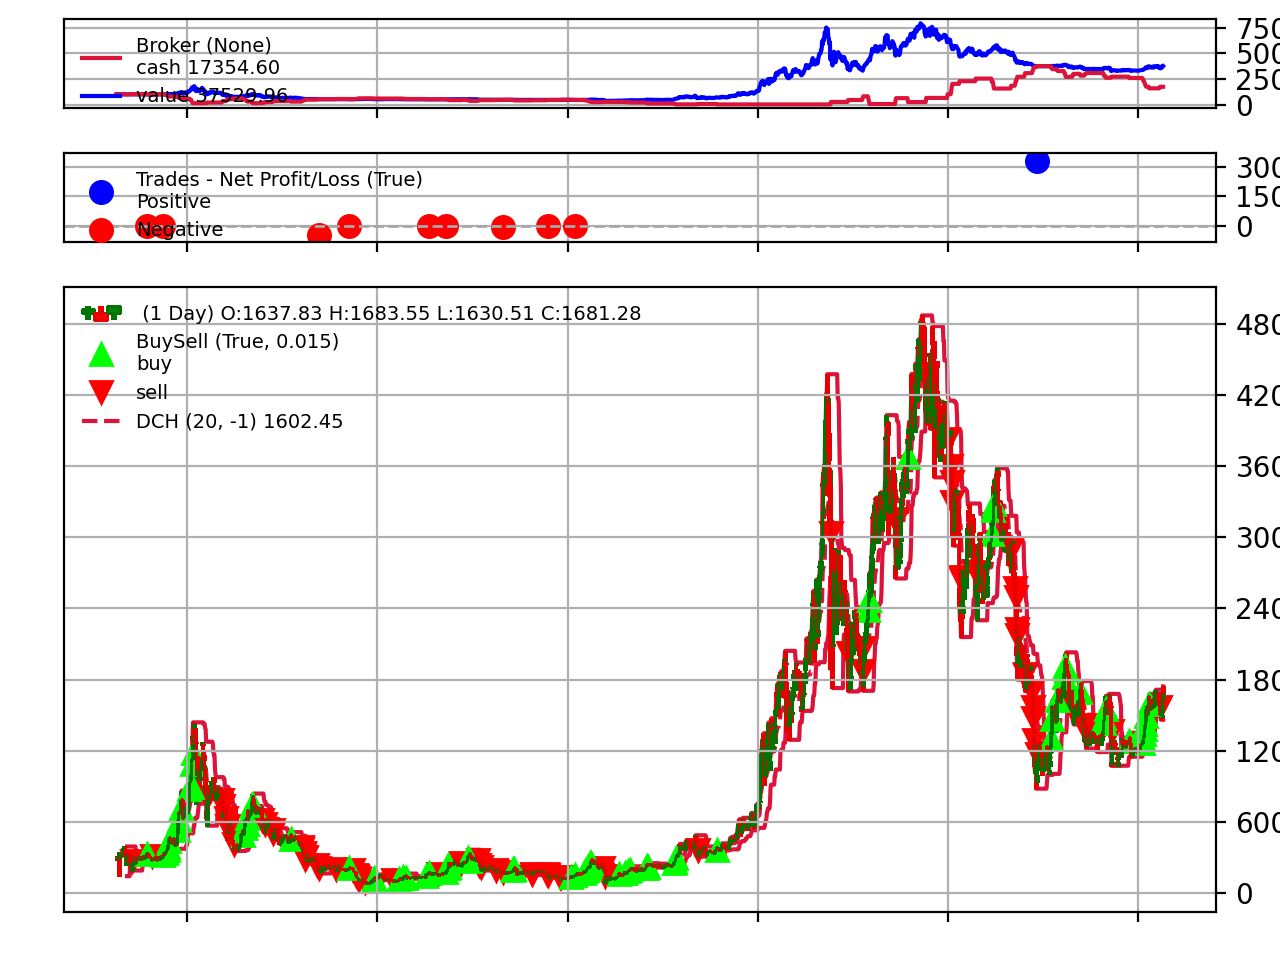

[[<Figure size 640x480 with 3 Axes>]]

In [58]:
# 初始化cerebro
cerebro = bt.Cerebro()
# feed data
cerebro.adddata(data)
# add strategy
#cerebro.addstrategy(MyStrategy)
cerebro.addstrategy(MyStrategy)

cerebro.addanalyzer(CashMarket, _name="cash_market")

# run backtest
result = cerebro.run()
# plot diagram
cerebro.plot(figsize=(230,130))

<IPython.core.display.Javascript object>


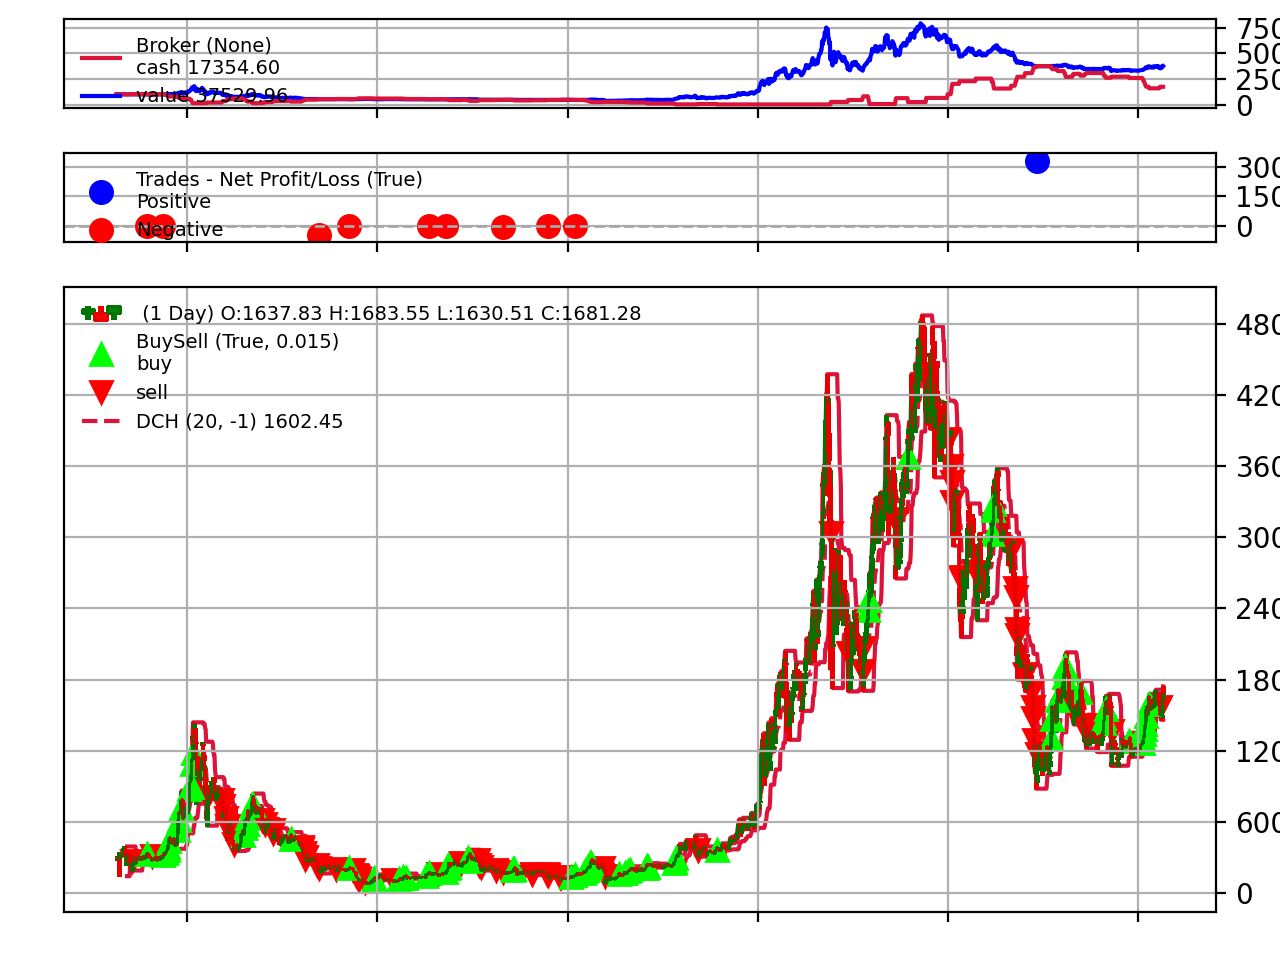

[[<Figure size 640x480 with 3 Axes>]]

In [59]:
cerebro.plot(barupfill = False, bardownfill = False, style = 'candle', plotdist = 0.5, 
                   figsize=(30,30), volume = False, barup = 'green', valuetags = False, subtxtsize = 7
                   )

In [60]:
dictionary = result[0].analyzers.getbyname("cash_market").get_analysis()

In [61]:
df = pd.DataFrame(dictionary).T
df.columns = ["Date", "Cash", "Value"]

In [62]:
df

,Date,Cash,Value
1,2017-08-17,10000.0,10000.0
2,2017-08-18,10000.0,10000.0
3,2017-08-19,10000.0,10000.0
4,2017-08-20,10000.0,10000.0
5,2017-08-21,10000.0,10000.0
...,...,...,...
2007,2023-02-13,17354.6,35417.48
2008,2023-02-14,17354.6,36023.12
2009,2023-02-15,17354.6,37453.64
2010,2023-02-16,17354.6,37008.68
